# CSE 252B: Computer Vision II, Winter 2018 – Assignment 4
### Instructor: Ben Ochoa
### Due: Wednesday, March 7, 2018, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains both math and programming problems.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX. Remember to show work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. Ask the instructor if in doubt.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

## Problem 1 (Programing): Feature Detection (20 points)
Download input data from the course website. The file price_center20.JPG
contains image 1 and the file price_center21.JPG contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
around 600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# open the input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.0
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.0

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()

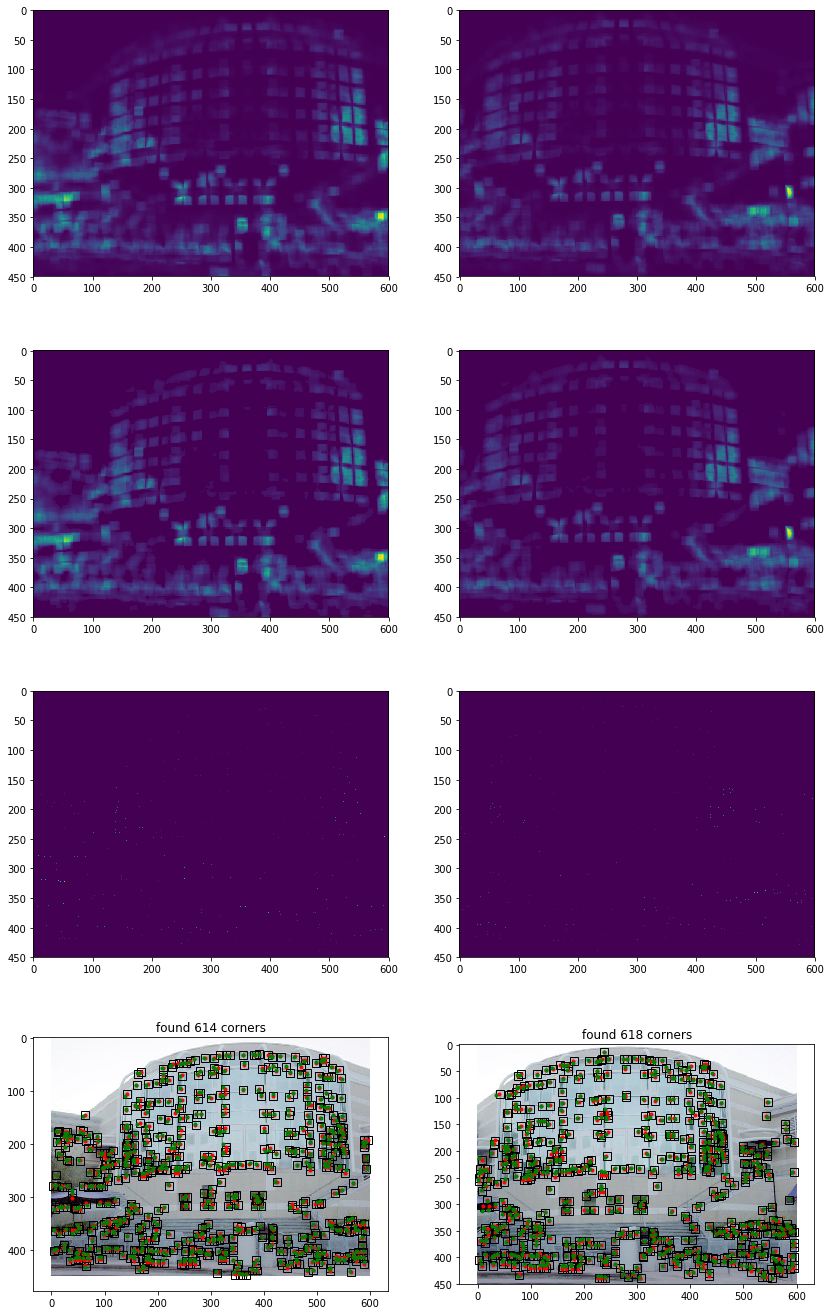

In [2]:
from scipy import signal
from scipy import ndimage

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def corner(I, w, t, w_nms):
    # inputs: 
    # I is the input image (may be mxn for BW or mxnx3 for RGB)
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the window used for nonmaximal supression
    # outputs:
    # J0 is the mxn image of minor eigenvalues of N before thresholding
    # J1 is the mxn image of minor eigenvalues of N after thresholding
    # J2 is the mxn image of minor eigenvalues of N after nonmaximal supression
    # pts0 is the 2xk list of coordinates of (pixel accurate) corners
    #     (ie. coordinates of nonzero values of J2)
    # pts1 is the 2xk list of coordinates of subpixel accurate corners
    #     found using the Forstner detector
    
    """your code here"""
    m,n = I.shape[:2]
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))
    J2 = np.zeros((m,n))
    Ix = np.zeros((m,n))
    Iy = np.zeros((m,n))
    
    I_gray = rgb2gray(I)
    gradient_kernel = 1.0/12*np.array([-1,8,0,-8,1])
    for i in range(m):
        Ix[i,:] = ndimage.convolve(I_gray[i,:],gradient_kernel, mode='reflect')
    for i in range(n):
        Iy[:,i] = np.transpose(ndimage.convolve(I_gray[:,i].T,gradient_kernel,mode='reflect'))
    
    Ixx = np.multiply(Ix,Ix)
    Ixy = np.multiply(Ix,Iy)
    Iyy = np.multiply(Iy,Iy)
    
    xIxx = np.zeros((m,n))
    yIyy = np.zeros((m,n))
    xIxy = np.zeros((m,n))
    yIxy = np.zeros((m,n))
    for i in range(m):
        xIxx[i,:] = i*Ixx[i,:]
        xIxy[i,:] = i*Ixy[i,:]
    for i in range(n):
        yIyy[:,i] = i*Iyy[:,i]
        yIxy[:,i] = i*Ixy[:,i]
        
    sum_kernel = np.ones((w,w))
    sum_w_Ixx = signal.convolve2d(Ixx,sum_kernel,'same','symm')
    sum_w_Ixy = signal.convolve2d(Ixy,sum_kernel,'same','symm')
    sum_w_Iyy = signal.convolve2d(Iyy,sum_kernel,'same','symm')
    sum_w_xIxx = signal.convolve2d(xIxx,sum_kernel,'same','symm')
    sum_w_xIxy = signal.convolve2d(xIxy,sum_kernel,'same','symm')
    sum_w_yIxy = signal.convolve2d(yIxy,sum_kernel,'same','symm')
    sum_w_yIyy = signal.convolve2d(yIyy,sum_kernel,'same','symm')
    
    det_N = sum_w_Ixx*sum_w_Iyy - sum_w_Ixy*sum_w_Ixy
    Tr_N = sum_w_Ixx+sum_w_Iyy
    for i in range(m):
        for j in range(n):
            if Tr_N[i,j]*Tr_N[i,j]-4*det_N[i,j]>=0:
                J0[i,j] = 1.0/2*(Tr_N[i,j]-np.sqrt(Tr_N[i,j]*Tr_N[i,j]-4*det_N[i,j]))
            else:
                J0[i,j] = 0
    for i in range(m):
        for j in range(n):
            if J0[i,j]<t: 
                J1[i,j] = 0
            else:
                J1[i,j] = J0[i,j]
    
    half_w_nms = int((w_nms-1)/2.0)
    for i in range(half_w_nms,m-half_w_nms):
        for j in range(half_w_nms,n-half_w_nms):
            window = J1[i-half_w_nms:i+half_w_nms,j-half_w_nms:j+half_w_nms]
            local_max = np.amax(window)
            if J1[i,j]==local_max:
                J2[i,j]=J1[i,j]
                
    pts0_x = []
    pts0_y = []
    pts1_x = []
    pts1_y = []
    for i in range(m):
        for j in range(n):
            if J2[i,j]!=0:
                pts0_x.append(j)
                pts0_y.append(i)
                A = np.array(([sum_w_Ixx[i,j],sum_w_Ixy[i,j]],
                             [sum_w_Ixy[i,j],sum_w_Iyy[i,j]]))
                b = np.array(([sum_w_xIxx[i,j]+sum_w_yIxy[i,j]],\
                              [sum_w_xIxy[i,j]+sum_w_yIyy[i,j]]))
                x = np.dot(np.linalg.inv(A),b)
                pts1_x.append(int(x[1]))
                pts1_y.append(int(x[0]))
                
    pts0 = np.array([pts0_x,pts0_y])
    pts1 = np.array([pts1_x,pts1_y])
    return J0, J1, J2, pts0, pts1


# parameters to tune
w=15
t=0.08
w_nms=7

# extract corners
J1_0, J1_1, J1_2, pts1_0, pts1_1 = corner(I1, w, t, w_nms)
J2_0, J2_1, J2_2, pts2_0, pts2_1 = corner(I2, w, t, w_nms)

# Display results
plt.figure(figsize=(14,24))

# show pre-thresholded corner heat map
plt.subplot(4,2,1)
plt.imshow(J1_0)
plt.subplot(4,2,2)
plt.imshow(J2_0)

# show thresholded corner heat map
plt.subplot(4,2,3)
plt.imshow(J1_1)
plt.subplot(4,2,4)
plt.imshow(J2_1)

# show corner heat map after nonmaximal supression
plt.subplot(4,2,5)
plt.imshow(J1_2)
plt.subplot(4,2,6)
plt.imshow(J2_2)

# show corners on origional images
ax = plt.subplot(4,2,7)
plt.imshow(I1)
# draw rectangles of size w around corners
for i in range(pts1_0.shape[1]):
    x,y = pts1_0[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.plot(pts1_0[0,:], pts1_0[1,:], '.r') # display pixel accurate corners
plt.plot(pts1_1[0,:], pts1_1[1,:], '.g') # display subpixel corners
plt.title('found %d corners'%pts1_0.shape[1])
ax = plt.subplot(4,2,8)
plt.imshow(I2)
for i in range(pts2_0.shape[1]):
    x,y = pts2_0[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.plot(pts2_0[0,:], pts2_0[1,:], '.r')
plt.plot(pts2_1[0,:], pts2_1[1,:], '.g')
plt.title('found %d corners'%pts2_0.shape[1])

plt.show()

## Problem 2 (Programing): Feature Matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that around 200 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

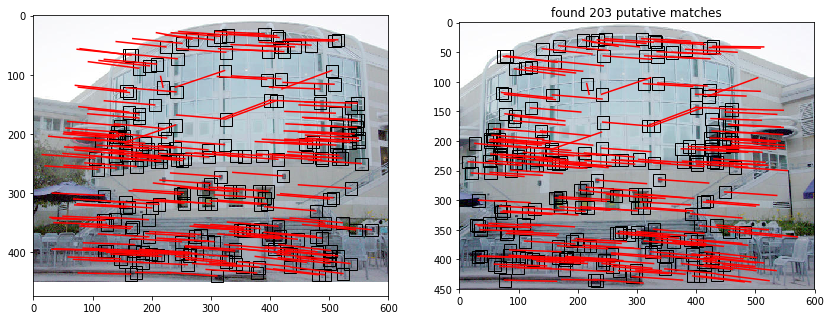

In [3]:
import math

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = np.array(a - mean2(a))
    b = np.array(b - mean2(b))

    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r

def match(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the proximity threshold
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    # scores is a vector of length k that contains the correlation
    #     coefficients of the matches
    
    """your code here"""
    I1_gray = rgb2gray(I1)
    I2_gray = rgb2gray(I2)
    m,n = I1.shape[:2]
    
    corr_m = np.zeros((pts1.shape[1],pts2.shape[1]))
    for i in range(pts1.shape[1]):
        for j in range(pts2.shape[1]):
            xmin1 = int(pts1[1,i]-(w-1)/2)
            ymin1 = int(pts1[0,i]-(w-1)/2)
            xmax1 = int(pts1[1,i]+(w-1)/2)
            ymax1 = int(pts1[0,i]+(w-1)/2)
            xmin2 = int(pts2[1,j]-(w-1)/2)
            ymin2 = int(pts2[0,j]-(w-1)/2)
            xmax2 = int(pts2[1,j]+(w-1)/2)
            ymax2 = int(pts2[0,j]+(w-1)/2)
            if xmin1<0 or ymin1<0 or xmin2<0 or ymin2<0: 
                corr_m[i,j] = -1
            elif xmax1>m or xmax2>m or ymax1>n or ymax2>n: 
                corr_m[i,j] = -1
            else:
                corr_m[i,j] = corr2(I1_gray[xmin1:xmax1,ymin1:ymax1],\
                                    I2_gray[xmin2:xmax2,ymin2:ymax2])
            
    mask = np.ones((pts1.shape[1],pts2.shape[1]))
    
    pair1 = []
    pair2 = []
    scores = []
    temp_corr_m = np.multiply(mask,corr_m)
    while t<np.max(temp_corr_m):
        max_index = np.argmax(temp_corr_m)
        max_corr = np.max(temp_corr_m)
        row = int(max_index/pts2.shape[1])
        col = int(max_index%pts2.shape[1])
        corr_m[row,col] = -1
        max_next = max([corr_m[row,:].max(),corr_m[:,col].max()])
        corr_m[row,col] = max_corr
        if (1-corr_m[row,col])<((1-max_next)*d):
            if math.sqrt(np.square(pts1[0,row]-pts2[0,col])+np.square(pts1[1,row]-pts2[1,col]))<p:
                pair1.append(row)
                pair2.append(col)
                scores.append(corr_m[row,col])
        mask[row,:] = np.zeros((1,pts2.shape[1]))
        mask[:,col] = np.zeros((1,pts1.shape[1]))
        temp_corr_m = np.multiply(mask,temp_corr_m)
    
    inds = np.array([pair1,pair2])
    scores = np.array(scores)
    
    return inds, scores

# parameters to tune
w1 = 21
t1 = 0.3
d1 = 0.9
p1 = 90

# do the matching
inds, scores = match(I1, I2, pts1_1, pts2_1, w1, t1, d1, p1)

# create new arays of points which are correspoinding
pts1 = pts1_1[:,inds[0,:]]
pts2 = pts2_1[:,inds[1,:]]

# display the results
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
plt.title('found %d putative matches'%inds.shape[1])
ax2.imshow(I2)
for i in range(inds.shape[1]):
    ii = inds[0,i]
    jj = inds[1,i]
    x1 = pts1_1[0,ii]
    x2 = pts2_1[0,jj]
    y1 = pts1_1[1,ii]
    y2 = pts2_1[1,jj]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w1/2,y1-w1/2),w1,w1, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w1/2,y2-w1/2),w1,w1, fill=False))
plt.show()
#print(scores)

## Problem 3 (Programing): Outlier Rejection (15 points)
The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 4-point algorithm (as described in
lecture) to estimate the planar projective transformation from the 2D points in
image 1 to the 2D points in image 2. Calculate the (squared) Sampson error as a
first order approximation to the geometric error.

hint: this problem has codimension 2

('inliers: ', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 202])
('inlier count: ', 192)
cost_MSAC=190.617893
||H_MSAC||=1.000000
H_MSAC
[[  1.09701506e-02  -1.24076437e-05  -9.85430336e-01]
 [  3

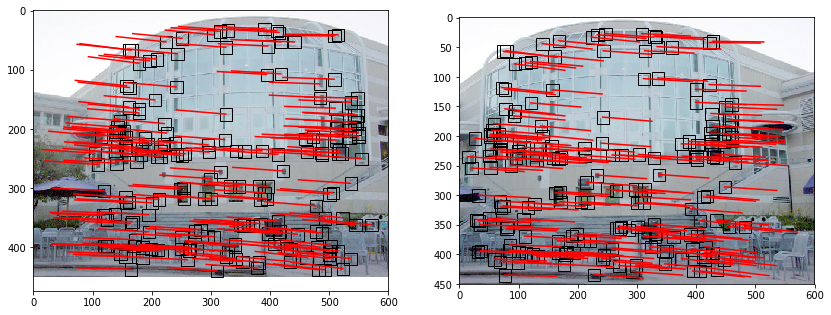

In [4]:
def toHomo(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))
def fromHomo(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return 1.0*x[:-1,:]/x[-1,:]
def Normalize(x):
    mu = np.mean(x,axis=1)
    var = np.sum(np.var(x,axis=1))
    s = np.sqrt((x.shape[0]+0.0)/var)
    H = np.zeros((x.shape[0]+1,x.shape[0]+1))
    for i in range(x.shape[0]):
        H[i,i] = s
        H[i,x.shape[0]] = -mu[i]*s
    H[x.shape[0],x.shape[0]] = 1
    x_homo = toHomo(x)
    x_normalized_homo = np.dot(H,x_homo)
    return (x_normalized_homo,H)

import random

def get_H_inv(pts, choice):
    A = np.hstack((toHomo(pts[:,choice[0]].reshape(2,1)),\
                   toHomo(pts[:,choice[1]].reshape(2,1)),\
                  toHomo(pts[:,choice[2]].reshape(2,1))))
    y = toHomo(pts[:,choice[3]].reshape(2,1))
    lambdas = np.linalg.inv(A).dot(y)
    H_inv = np.hstack((lambdas[0]*toHomo(pts[:,choice[0]].reshape(2,1)),\
                       lambdas[1]*toHomo(pts[:,choice[1]].reshape(2,1)),\
                      lambdas[2]*toHomo(pts[:,choice[2]].reshape(2,1))))
    return H_inv

def get_H(pts1, pts2, choice):
    H1_inv = get_H_inv(pts1, choice)
    H2_inv = get_H_inv(pts2, choice)
    H = H2_inv.dot(np.linalg.inv(H1_inv))
    return H

def Sampson_error(pts1, pts2, H):
    error_vec = []
    Sampson_vec = []
    for i in range(pts1.shape[1]):
        x1 = pts1[0,i]
        x2 = pts2[0,i]
        y1 = pts1[1,i]
        y2 = pts2[1,i]
        
        A = np.array([[0,0,0,-x1,-y1,-1,y2*x1,y2*y1,y2],\
                      [x1,y1,1,0,0,0,-x2*x1,-x2*y1,-x2]])
        h = np.vstack((H[0,:].reshape(3,1),H[1,:].reshape(3,1),H[2,:].reshape(3,1)))
        epsil = A.dot(h)
        J = np.array([[-H[1,0]+y2*H[2,0],-H[1,1]+y2*H[2,1],0,x1*H[2,0]+y1*H[2,1]+H[2,2]],\
                      [H[0,0]-x2*H[2,0],H[0,1]-x2*H[2,1],-(x1*H[2,0]+y1*H[2,1]+H[2,2]),0]])
        lambda_s = np.linalg.inv(J.dot(J.T)).dot(-epsil)
        delta = J.T.dot(lambda_s)
        Sampson_vec.append(delta)
        error = delta.T.dot(delta)
        error_vec.append(error)
    return error_vec,np.array(Sampson_vec).reshape(pts1.shape[1],delta.shape[0]).T

def consensus_cost(error,t,record=False):
    cost = 0
    num_inlier = 0
    inliers = []
    for i in range(len(error)):
        if error[i]<=t:
            cost = cost+error[i]
            num_inlier = num_inlier+1
            if record:
                inliers.append(i)
        else:
            cost = cost+t
    return cost,num_inlier,inliers

def MSAC(pts1, pts2, max_iters):
    """your code here"""

    consensus_Mincost = np.inf
    # when alpha=0.95 codimension=2
    distance_threshold = 5.9915
    trials = 0
    
    while trials < max_iters:
        choice = random.sample(range(pts1.shape[1]),4)
        H = get_H(pts1, pts2, choice)
        error,Sampson_vec = Sampson_error(pts1, pts2, H)
        cost,num_inlier,inliers = consensus_cost(error,distance_threshold)
        if cost<consensus_Mincost:
            consensus_Mincost = cost
            H_best = H

            s = 4 #sample size
            p = 0.99
            w = 1.0*num_inlier/pts1.shape[1]
            if w>0:
                max_iters = np.log(1-p)/np.log(1-w**s)  
        trials = trials+1
    
    error,Sampson_vec = Sampson_error(pts1, pts2, H_best)
    cost,num_inlier,inliers = consensus_cost(error,distance_threshold,record=True)
    iters = trials # number of MSAC itterations executed
    return 1.0*H_best/np.sqrt(np.sum(H_best**2)), inliers, cost, iters

# MSAC hyperparameters 
# You should pass these hyperparameters as additional paramters to MSAC(...)
max_iters=np.inf

H_MSAC, inliers, cost_MSAC, iters_MSAC = MSAC(pts1, pts2, max_iters)
print('inliers: ', inliers)
print('inlier count: ', len(inliers))

print('cost_MSAC=%f'%cost_MSAC)
print('||H_MSAC||=%f'%np.sqrt(np.sum(H_MSAC**2)))
print('H_MSAC')
print(H_MSAC/np.sqrt(np.sum(H_MSAC**2)))

# display the results
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
for i in range(inds[:,inliers].shape[1]):
    ii = inds[0,inliers[i]]
    jj = inds[1,inliers[i]]
    x1 = pts1_1[0,ii]
    x2 = pts2_1[0,jj]
    y1 = pts1_1[1,ii]
    y2 = pts2_1[1,jj]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w1/2,y1-w1/2),w1,w1, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w1/2,y2-w1/2),w1,w1, fill=False))
plt.show()

## Problem 4 (Programing): Linear Estimate (15 points)
  Estimate the planar projective transformation $\boldsymbol{H}_\text{DLT}$
  from the resulting set of inlier correspondences using the direct
  linear transformation (DLT) algorithm (with data normalization).
  You must express $\boldsymbol{x}'_i = \boldsymbol{H} \boldsymbol{x}_i$ as
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$ (not
  $\boldsymbol{x}'_i \times \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$), where
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{x}'_i = \boldsymbol{0}$, when forming the
  solution.  Include the numerical values of the resulting
  $\boldsymbol{H}_\text{DLT}$, scaled such that
  $||\boldsymbol{H}_\text{DLT}||_\text{Fro} = 1$

In [5]:
def sinc(x):
    if x == 0:
        return 1
    else:
        return np.sin(x) / x
    
def sinc_prime(x):
    if x == 0:
        return 0
    else:
        return np.cos(x)/x-np.sin(x)/(x**2)
    
def Parameterization(v):
    v = v/np.linalg.norm(v)
    a = v[0,0]
    b = v[1:]
    v_i = 2.0/sinc(np.arccos(a))*b
    
    if np.linalg.norm(v_i)>np.pi:
        v_i = (1-2.0*np.pi/np.linalg.norm(v_i)*np.ceil((np.linalg.norm(v_i)-np.pi)/(2.0*np.pi)))*v_i
    return v_i.reshape(b.shape[0],1)

def Deparameterization(v):
    if np.linalg.norm(v)>np.pi:
        v = (1-2.0*np.pi/np.linalg.norm(v)*np.ceil((np.linalg.norm(v)-np.pi)/(2.0*np.pi)))*v
    a = np.cos(np.linalg.norm(v)/2.0)
    b = sinc(np.linalg.norm(v)/2.0)/2.0*v
    return np.vstack((a,b))

def Points_adjust(pts,Sampson_vec):
    pts_par = []
    pts_depar = []
    for i in range(pts.shape[1]):
        x1 = pts[0,i]+Sampson_vec[0,i]
        y1 = pts[1,i]+Sampson_vec[1,i]
        v = toHomo(np.array([x1,y1]).reshape(2,1))
        v = v/np.linalg.norm(v)
        pts_par.append(Parameterization(v))
        pts_depar.append(fromHomo(v))
    return np.array(pts_par).reshape(pts.shape[1],2).T,np.array(pts_depar).reshape(pts.shape[1],2).T

def HomoTransfer(x,H):
    return fromHomo(H.dot(toHomo(x)))

def DLT(pts1, pts2):
    """your code here"""
    
    #data normalization
    pts1_normalized_homo,T = Normalize(pts1)
    pts2_normalized_homo,U = Normalize(pts2)
    pts1_normalized = fromHomo(pts1_normalized_homo)
    pts2_normalized = fromHomo(pts2_normalized_homo)
    s_1 = T[0,0]**2
    s_2 = U[0,0]**2
    sigma_1 = s_1*np.eye(2)
    sigma_2 = s_2*np.eye(2)
    
    #DLT calculation
    A = np.zeros((1,9))
    e = np.zeros((3,1))
    e[0,0] = 1
    for i in range(pts1.shape[1]):
        pts1_i = np.array([pts1_normalized_homo[:,i]])
        pts2_i = np.array([pts2_normalized_homo[:,i]]).T
        v = pts2_i + np.sign(pts2_i[0,0])*np.linalg.norm(pts2_i,2)*e
        H_v = np.identity(3) - 2.0*np.dot(v,v.T)/np.dot(v.T,v)
        x_perp = H_v[1:,:]
        A = np.vstack((A,np.kron(x_perp,pts1_i)))
    U_svd, s, V = np.linalg.svd(A[1:,:], full_matrices=False)
    H = np.array([V[8,0:3],V[8,3:6],V[8,6:]])
    H = H/np.linalg.norm(H)
    
    #calculate the LM cost
    error,Sampson_vec = Sampson_error(pts1_normalized, pts2_normalized, H)
    pts_scene_par,pts_scene = Points_adjust(pts1_normalized,Sampson_vec)
    cost = 0
    for i in range(pts1.shape[1]):
        epsil_i = pts1_normalized[:,i].reshape(2,1) - pts_scene[:,i].reshape(2,1)
        epsil_i_prime = pts2_normalized[:,i].reshape(2,1) - HomoTransfer(pts_scene[:,i].reshape(2,1),H)
        cost = cost + epsil_i.T.dot(np.linalg.inv(sigma_1)).dot(epsil_i)+\
            epsil_i_prime.T.dot(np.linalg.inv(sigma_2)).dot(epsil_i_prime)
    H = np.linalg.inv(U).dot(H).dot(T)
    return H/np.sqrt(np.sum(H**2)), cost

H_DLT, cost_DLT = DLT(pts1[:,inliers], pts2[:,inliers])
print('cost_DLT=%f'%cost_DLT)
print('||H_DLT||=%f'%np.sqrt(np.sum(H_DLT**2)))
print('H_DLT')
print(H_DLT/np.sqrt(np.sum(H_DLT**2)))

cost_DLT=87.293804
||H_DLT||=1.000000
H_DLT
[[  1.09495823e-02  -1.62235757e-05  -9.84435615e-01]
 [  3.26441933e-04   1.06464240e-02  -1.74784115e-01]
 [  1.26984913e-06   1.02960951e-07   1.01826125e-02]]


## Problem 5 (Programing): Nonlinear Estimate (45 points) 
 Use $\boldsymbol{H}_\text{DLT}$ and the Sampson corrected points (in image 1) as an initial estimate to an iterative estimation method,
  specifically the sparse Levenberg-Marquardt algorithm, to
  determine the Maximum Likelihood estimate of the planar projective
  transformation that minimizes the reprojection error.  You must
  parameterize the planar projective transformation matrix and the
  homogeneous 2D scene points that are being adjusted using the
  parameterization of homogeneous vectors (see section A6.9.2 (page 624) of the textbook, and the corrections and errata).
  Show the numerical values for the final estimate of the planar projective
  transformation matrix $\boldsymbol{H}_\text{LM}$, scaled such that
  $||\boldsymbol{H}_\text{LM}||_\text{Fro} = 1$.

In [6]:
def Parameterization_prime(v):
    ppprime = np.zeros((v.shape[0]+1,v.shape[0]))
    b = sinc(np.linalg.norm(v)/2.0)/2.0*v
    if np.linalg.norm(v) == 0:
        ppprime[1:,:] = 0.5*np.identity(v.shape[0])
    else:
        ppprime[0,:] = -1.0/2*b.T
        ppprime[1:,:] = sinc(np.linalg.norm(v)/2.0)/2.0*np.identity(v.shape[0])+\
        1.0/(4*np.linalg.norm(v))*sinc_prime(np.linalg.norm(v)/2.0)*np.dot(v,v.T)
    
    return ppprime

def derivative_xprime_h(x,x_prime,H):
    w_prime = H[2,:].reshape(1,3).dot(toHomo(x))
    xprime_h = 1.0/w_prime*np.array([[x[0,0],x[1,0],1,0,0,0,-x_prime[0,0]*x[0,0],-x_prime[0,0]*x[1,0],-x_prime[0,0]],\
                         [0,0,0,x[0,0],x[1,0],1,-x_prime[1,0]*x[0,0],-x_prime[1,0]*x[1,0],-x_prime[1,0]]])
    return xprime_h

def derivative_xprime_x(x,x_prime,H):
    w_prime = H[2,:].reshape(1,3).dot(toHomo(x))
    xprime_x = 1.0/w_prime*np.array([[H[0,0]-x_prime[0,0]*H[2,0],\
                                      H[0,1]-x_prime[0,0]*H[2,1],\
                                      H[0,2]-x_prime[0,0]*H[2,2]],\
                                     [H[1,0]-x_prime[1,0]*H[2,0],\
                                      H[1,1]-x_prime[1,0]*H[2,1],\
                                      H[1,2]-x_prime[1,0]*H[2,2]]])
    return xprime_x

def Jacobian(pts1,pts2,pts_scene_par,pts_scene,H,h_para):
    A = derivative_xprime_h(pts_scene,pts2,H).dot(Parameterization_prime(h_para))
    v = Parameterization_prime(pts_scene_par)
    B = derivative_xprime_x(pts_scene,pts1,H).dot(v)
    B_prime = derivative_xprime_x(pts_scene,pts2,H).dot(v)
    return A,B,B_prime


def LMstep(H, pts1, pts2, pts_scene, pts_scene_par, sigma_1, sigma_2, l, v):
    """your code here"""
    
    flag = True
    iter_num = 0
    
    pts_scene_vec_best = pts_scene
    pts_scene_par_vec_best = pts_scene_par
    
    h = np.vstack((H[0,:].reshape(3,1),H[1,:].reshape(3,1),H[2,:].reshape(3,1)))
    h_para = Parameterization(h)      
    
    U = np.zeros((8,8))
    epsil_a_prime = np.zeros((8,1))
    V_i = []
    W_i = []
    epsil_bi = []
    cost = 0
    #get the normal equations matrix
    for i in range(pts1.shape[1]):
        A,B,B_prime = Jacobian(pts1[:,i].reshape(2,1),pts2[:,i].reshape(2,1),pts_scene_par[:,i].reshape(2,1),pts_scene[:,i].reshape(2,1),H,h_para)
        U = U + A.T.dot(np.linalg.inv(sigma_2)).dot(A)
        V_i.append(B.T.dot(np.linalg.inv(sigma_1)).dot(B)+\
                   B_prime.T.dot(np.linalg.inv(sigma_2)).dot(B_prime))
        W_i.append(A.T.dot(np.linalg.inv(sigma_2)).dot(B_prime))
        epsil_i = pts1[:,i].reshape(2,1) - pts_scene[:,i].reshape(2,1)
        epsil_i_prime = pts2[:,i].reshape(2,1) - HomoTransfer(pts_scene[:,i].reshape(2,1),H)
        cost = cost + epsil_i.T.dot(np.linalg.inv(sigma_1)).dot(epsil_i) + epsil_i_prime.T.dot(np.linalg.inv(sigma_2)).dot(epsil_i_prime)
        epsil_a_prime = epsil_a_prime + A.T.dot(np.linalg.inv(sigma_2)).dot(epsil_i_prime)
        epsil_bi.append(B.T.dot(np.linalg.inv(sigma_1)).dot(epsil_i)+B_prime.T.dot(np.linalg.inv(sigma_2)).dot(epsil_i_prime))
    
    #LM step
    while(flag):
        if iter_num>20:
            flag = False
        S = np.zeros((8,8))
        e = np.zeros((8,1))
        for j in range(pts1.shape[1]):
            S = S - W_i[j].dot(np.linalg.inv(V_i[j]+l*np.eye(2))).dot(W_i[j].T)
            e = e - W_i[j].dot(np.linalg.inv(V_i[j]+l*np.eye(2))).dot(epsil_bi[j])
        S = S + U + l*np.identity(U.shape[0])
        e = e + epsil_a_prime
        delta_a_prime = np.linalg.inv(S).dot(e)
        h_para_temp = h_para + delta_a_prime
        H_temp = Deparameterization(h_para_temp).reshape(3,3)
        cost_temp = 0
        pts_scene_tem_vec = []
        pts_scene_vec = []
        pts_scene_par_vec = []
        for i in range(pts1.shape[1]):
            delta_bi = (np.linalg.inv(V_i[i]+l*np.identity(V_i[i].shape[0]))).dot(epsil_bi[i]-W_i[i].T.dot(delta_a_prime))
            pts_scene_tem_par = pts_scene_par[:,i].reshape(2,1) + delta_bi
            pts_scene_tem_depara = fromHomo(Deparameterization(pts_scene_tem_par))
            pts_scene_vec.append(pts_scene_tem_depara)
            pts_scene_par_vec.append(pts_scene_tem_par)
            epsil_i_temp = pts1[:,i].reshape(2,1) - pts_scene_tem_depara
            epsil_i_prime_temp = pts2[:,i].reshape(2,1) - HomoTransfer(pts_scene_tem_depara,H_temp)
            cost_temp = cost_temp + epsil_i_temp.T.dot(np.linalg.inv(sigma_1)).dot(epsil_i_temp) + \
            epsil_i_prime_temp.T.dot(np.linalg.inv(sigma_2)).dot(epsil_i_prime_temp)
            
        if cost_temp<cost:
            H = H_temp
            l = 1.0*l/v
            cost = cost_temp
            pts_scene_vec_best = np.array(pts_scene_vec).reshape(pts1.shape[1],2).T
            pts_scene_par_vec_best = np.array(pts_scene_par_vec).reshape(pts1.shape[1],2).T
            flag = False
        else:
            l = v*l
            iter_num = iter_num + 1
            
    return H, cost, pts_scene_vec_best, pts_scene_par_vec_best, l


# LM hyperparameters
l=.001
v=10
max_iters=10

H_LM = H_DLT

#data normalization
pts1_in = pts1[:,inliers]
pts2_in = pts2[:,inliers]
pts1_normalized_homo,T = Normalize(pts1_in)
pts2_normalized_homo,N = Normalize(pts2_in)
s_1 = T[0,0]**2
s_2 = N[0,0]**2
sigma_1 = s_1*np.eye(2)
sigma_2 = s_2*np.eye(2)

pts1_normalized = fromHomo(pts1_normalized_homo)
pts2_normalized = fromHomo(pts2_normalized_homo)
H_LM = N.dot(H_LM).dot(np.linalg.inv(T))

#get the scene points
error,Sampson_vec = Sampson_error(pts1_normalized, pts2_normalized, H_LM)
pts_scene_par,pts_scene = Points_adjust(pts1_normalized,Sampson_vec)

# LM optimization loop
for i in range(max_iters):
    H_LM, cost_LM, pts_scene, pts_scene_par, l = LMstep(H_LM, pts1_normalized, pts2_normalized,\
                                                        pts_scene, pts_scene_par, sigma_1, sigma_2, l, v)
    print ('iter %d cost %f'%(i+1, cost_LM))

#denormalize H
H_LM = np.linalg.inv(N).dot(H_LM).dot(T)
H_LM = H_LM/np.sqrt(np.sum(H_LM**2))

print('||H_LM||=%f'%np.sqrt(np.sum(H_LM**2)))
print('H_LM')
print(H_LM/np.sqrt(np.sum(H_LM**2)))

iter 1 cost 87.291377
iter 2 cost 87.239253
iter 3 cost 87.239180
iter 4 cost 87.239180
iter 5 cost 87.239180
iter 6 cost 87.239180
iter 7 cost 87.239180
iter 8 cost 87.239180
iter 9 cost 87.239180
iter 10 cost 87.239180
||H_LM||=1.000000
H_LM
[[  1.09540522e-02  -1.65496132e-05  -9.84436937e-01]
 [  3.26454767e-04   1.06520057e-02  -1.74775645e-01]
 [  1.26894369e-06   9.99743587e-08   1.01895967e-02]]
